In [3]:
# build linear model, use the scikit-learn pkg to keep in same universe as machine learning
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
# load the data from excel
import pandas as pd
df = pd.read_excel(r'C:\Users\B76329\OneDrive - Kimberly-Clark\Data Science\python\mta\data\mta-results-ubk.xlsx', sheet_name='data')

In [26]:
df['effectiveness'] = df.dueto_vol / df.exposure * 1000000
df['roi'] = df.profit / df.spend
df['cpm'] = df.spend / df.exposure * 1000

In [28]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)
#plt.matshow(df.corr())




c:\users\b76329\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,margin,dueto_vol,mrev,profit,spend,exposure,Year,Effectiveness,effectiveness,roi,cpm
margin,1,6.4e-17,nan,-8e-17,5.7e-16,-5.7e-16,nan,1.4e-15,1.4e-15,1.4e-15,2.6e-15
dueto_vol,6.4e-17,1,nan,1,0.47,0.47,nan,0.22,0.22,0.29,-0.1
mrev,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
profit,-8e-17,1,nan,1,0.47,0.47,nan,0.22,0.22,0.29,-0.1
spend,5.7e-16,0.47,nan,0.47,1,0.93,nan,0.05,0.05,0.08,-0.1
exposure,-5.7e-16,0.47,nan,0.47,0.93,1,nan,0.037,0.037,0.072,-0.11
Year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Effectiveness,1.4e-15,0.22,nan,0.22,0.05,0.037,nan,1,1,0.97,-0.16
effectiveness,1.4e-15,0.22,nan,0.22,0.05,0.037,nan,1,1,0.97,-0.16
roi,1.4e-15,0.29,nan,0.29,0.08,0.072,nan,0.97,0.97,1,-0.24


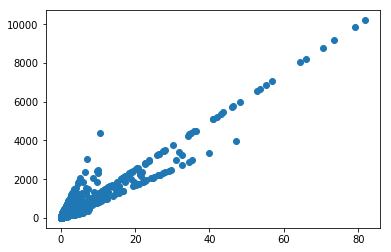

In [31]:
plt.scatter(df.roi, df.effectiveness)
# roi and effectiveness are highliy correlated
#what are these separate vectors? assuming they are different margins

In [34]:
df.margin.unique()

array([56.18])

In [42]:
# nope, there is only one margin
# there are some very high roi in here, let's filter those out
id = df[df['roi'] >= 10].index
df2 = df.drop(id)

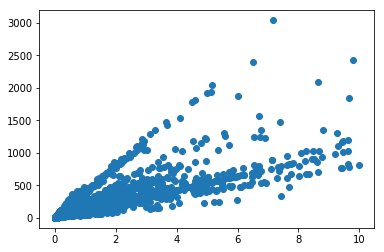

In [44]:
plt.scatter(df2.roi, df2.effectiveness)

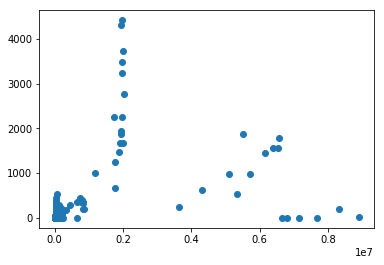

In [51]:
# still have vectors there
# let's look at volume and exposure
plt.scatter(df.exposure, df.dueto_vol)


In [52]:
# some outliers for sure with very high volumes, let's drop these
df3 = df.drop(df[df.dueto_vol > 1].index)

In [56]:
df3.dueto_vol.max()

0.9959276667

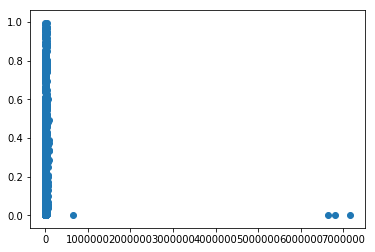

In [57]:
plt.scatter(df3.exposure, df3.dueto_vol)

In [116]:
# the problem here is that these are not individual observations, they are at a placement/creative/device level (or something)
# indications from training deck point to campaign + site + placement + creative + device + week level
# let's compare those to the total number of observations
len(df) # 6176 rows
#print(df.head())
#df['key'] = ''.join([df['campaignid'], df['siteid']])
df['key'] = df[['campaignid', 'siteid', 'placementid', 'creativeid', 'devicetype', 'week']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
len(df.key.unique())

6176

In [121]:
# yes, there are the same amount of uniques in this key as there are rows in the data
# let's verify by creating another key but leaving off a column
df['key2'] = df[['campaignid', 'siteid', 'creativeid', 'devicetype', 'week']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
len(df.key2.unique())

4753

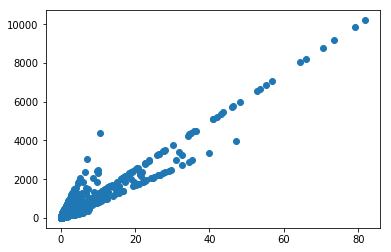

In [129]:
# yes, that works
# this means the rows are not directly comparible because they may contain dramatically different impression quantities
# let's go back to the beginning and look for outliers, but we can't look at absolute values, only ratios
plt.scatter(df.roi, df.effectiveness)


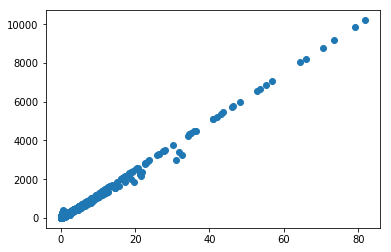

In [133]:
# clearly effectiveness drives ROI. Still would like to understand these clear vectors
# let's try to plot by campaignid
dfa = df[df['campaignid'] == 'nlsn156189']
plt.scatter(dfa.roi, dfa.effectiveness)

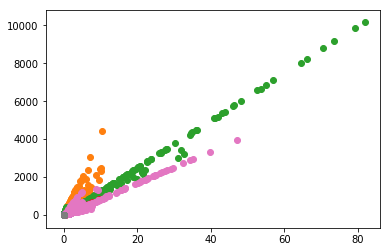

In [156]:
# yep, let's plot each campaign in a different color
for cid in df['campaignid'].unique():
    dfa = df[df['campaignid'] == cid]
    plt.scatter(dfa.roi, dfa.effectiveness)
#plt.scatter(dfa.roi, dfa.effectiveness)

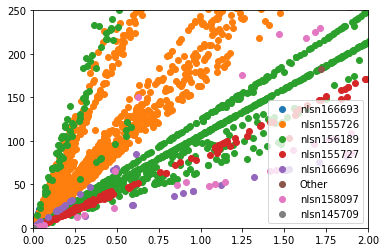

In [203]:
# yes, it's clear that the campaignid is a particular segment of results
# there is something else here too. let's zoom in a bit
fig, ax = plt.subplots()
ax.set_xlim(0,2)
ax.set_ylim(0,250)
for cid in df['campaignid'].unique():
    dfa = df[df['campaignid'] == cid]
    plt.scatter(dfa.roi, dfa.effectiveness, label=cid)
ax.legend(loc='best')

In [188]:
# way more vectors apparhent here, 20 or more visible, let's find another factor that may have 20 unique values
# options: ['campaignid', 'siteid', 'placementid', 'creativeid', 'devicetype', 'week']
rf = pd.DataFrame()
rf['campaigns'] = ['campaignid', 'siteid', 'placementid', 'creativeid', 'devicetype', 'week']
counts = []
for key in rf['keys']:
    counts.append(len(df[key].unique()))
rf['counts'] = counts
rf

,keys,counts
0,campaignid,8
1,siteid,6
2,placementid,77
3,creativeid,262
4,devicetype,6
5,week,21


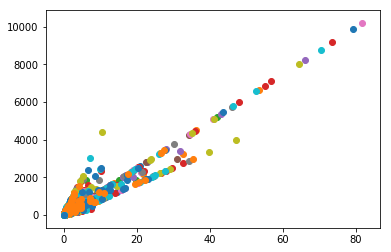

In [194]:
# week has a close count, let's try this one
for wk in df['week'].unique():
    dfw = df[df['week'] == wk]
    plt.scatter(dfw.roi, dfw.effectiveness)

<Figure size 432x288 with 0 Axes>

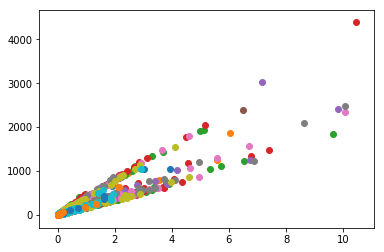

In [213]:
# that is too messy, let's take one campaign then  split by week
plt.clf()
fig, ax = plt.subplots()
df1 = df[df['campaignid']=='nlsn155726']
for wk in df1['week'].unique():
    #print(wk)
    dfw = df1[df1['week'] == wk]
    #print(dfw.head)
    plt.scatter(dfw.roi, dfw.effectiveness, label=wk)
#ax.legend(loc='best')


<Figure size 432x288 with 0 Axes>

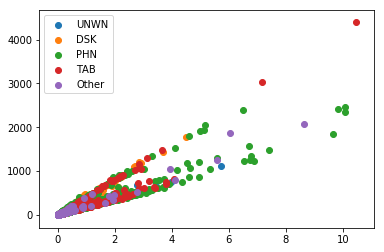

In [215]:
# I don't think it's week. Let's try site and device type
plt.clf()
fig, ax = plt.subplots()
for dv in df1['devicetype'].unique():
    dft = df1[df1['devicetype'] == dv]
    plt.scatter(dft.roi, dft.effectiveness, label=dv)
ax.legend(loc='best')

<Figure size 432x288 with 0 Axes>

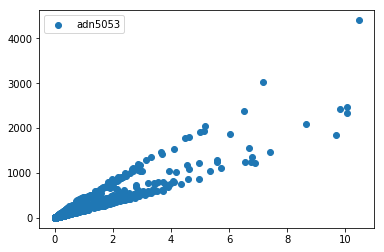

In [216]:
plt.clf()
fig, ax = plt.subplots()
for site in df1['siteid'].unique():
    dft = df1[df1['siteid'] == site]
    plt.scatter(dft.roi, dft.effectiveness, label=site)
ax.legend(loc='best')

<Figure size 432x288 with 0 Axes>

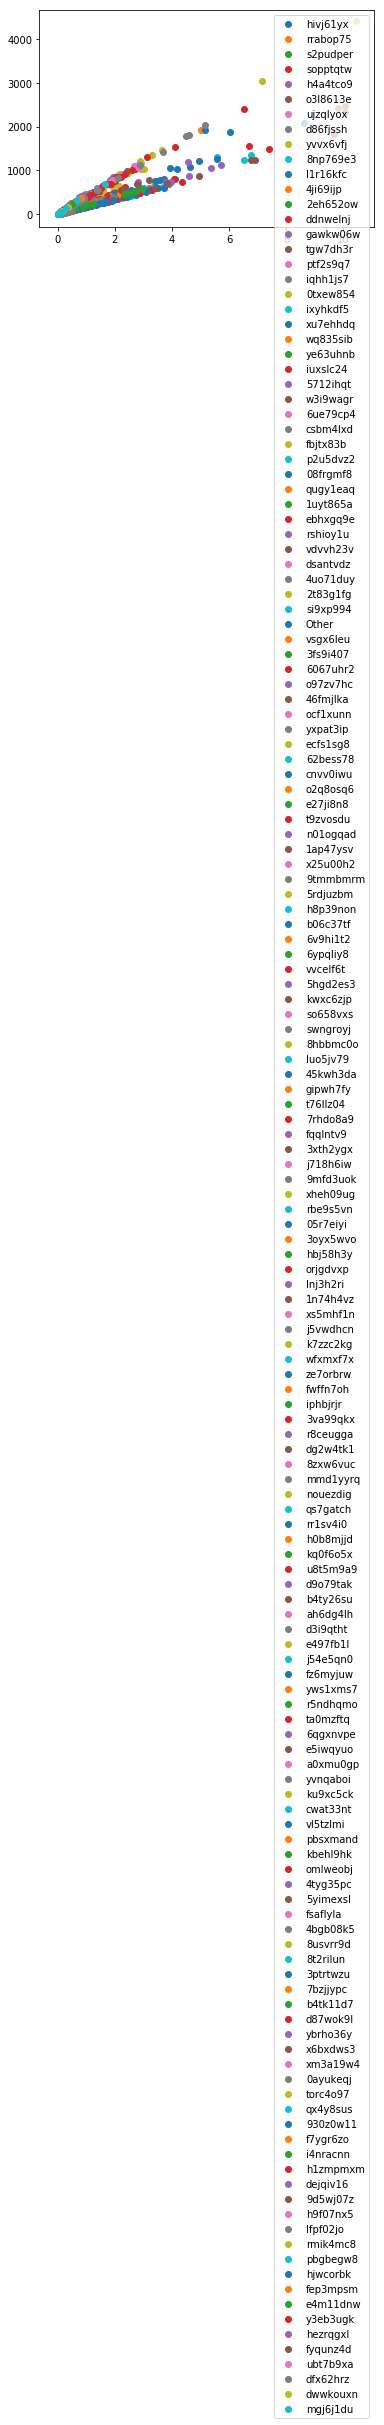

In [217]:
# nope. try some more. creativeid and placementid are all that's left
plt.clf()
fig, ax = plt.subplots()
field = 'creativeid'
for f in df1[field].unique():
    dftmp = df1[df1[field] == f]
    plt.scatter(dftmp.roi, dftmp.effectiveness, label=f)
ax.legend(loc='best')

<Figure size 432x288 with 0 Axes>

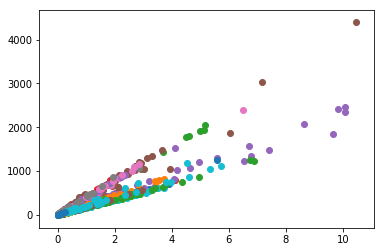

In [219]:
# now applying some reusable code
plt.clf()
fig, ax = plt.subplots()
field = 'placementid'
for f in df1[field].unique():
    dftmp = df1[df1[field] == f]
    plt.scatter(dftmp.roi, dftmp.effectiveness, label=f)
#ax.legend(loc='best')

<Figure size 432x288 with 0 Axes>

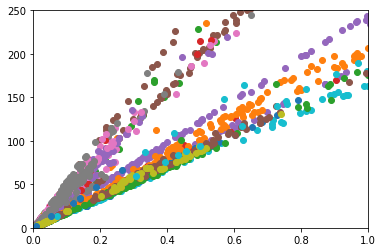

In [222]:
# i am seeing a bit more of an overlap using placement, let's zoom in a bit
plt.clf()
fig, ax = plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(0,250)

field = 'placementid'
for f in df1[field].unique():
    dftmp = df1[df1[field] == f]
    plt.scatter(dftmp.roi, dftmp.effectiveness, label=f)

In [224]:
# yeah placement is it. how many placements are there?
len(df1['placementid'].unique())

21

In [226]:
# this is making sense. what's placement anyway? let's look at the placement values
df1['placementid'].unique()

array(['8bt7o3c', '9x0yxqf', 'fwh7am1', 'j5u72bt', 'kcjuj43', 'ku1n0b6',
       'lwcx1mw', 'p9d6g8z', 's0ttdfv', 't6h6oxm', 't6idjp5', 'tjkgvc2',
       'y2kb8ro', 'ybsfwre', 'yh94jay', 'e4zn0y7', 'f2r319m', 'twxa1au',
       'utmj5b2', '0e5juhs', 'Other'], dtype=object)

In [ ]:
# well that doesn't tell us anything at all...

# Notes on Placement

### Tim:

The placementID's refer to the line items within our plnas that are broken out specifically to target audiences in desktop/web vs. mobile app. Think of those as media placements that are set up to specifically target that audience within the designated inventory. In that sense, each audience is assigned to 2 distinct placements - one for web and one for app inventory.

The placement is essentially the level of our plans where we assign the media budget to. It's at that level where the creative messaging is applied, the audience data is connected, and the spend is set up - all before going through the trafficking process when going live.

### Chris:

This is the level whewre pacing is determinined as well if I'm thinking about this correctly

### Tim:

Absolutely right. It's data at that level that we assess each week for pacing/underdelivery concerns in our optimization/data review sessions

** Given this, we can probably count on placement as a primary indicator of effectiveness. It's a combination of a number of things that make it unique, with the exception of week.
Let's look at ROI by placement. Then we can start to look for commonality amoung placements that have healthy ROI. **